In [37]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('seaborn-white')

color = '#87ceeb'

In [3]:
df = pd.read_csv('../data/TwoGroupIQ.csv')

In [8]:
df.groupby('Group').describe()

Score                                                        
           count        mean        std   min   25%    50%    75%    max
Group                                                                   
Placebo     57.0  100.035088  17.894497  59.0  91.0  100.0  108.0  184.0
Smart Drug  63.0  107.841270  25.445201  50.0  96.0  107.0  119.0  208.0

In [40]:
y = df[df['Group'] == 'Smart Drug']['Score']

#### Estimating mean and standard deviation of normal distribution 

In [41]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

In [42]:
trace = pm.sample(model=model, draws=2000, cores=-1, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 2500/2500 [00:01<00:00, 1503.47it/s]
The acceptance probability does not match the target. It is 0.8856708967735292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900457514432562, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89667215515234, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133d18240>,
      dtype=object)

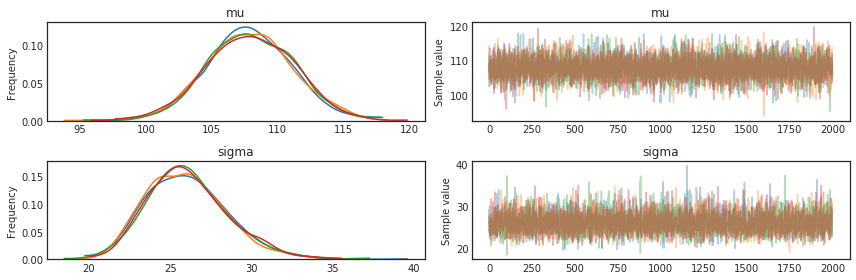

In [43]:
pm.traceplot(trace)

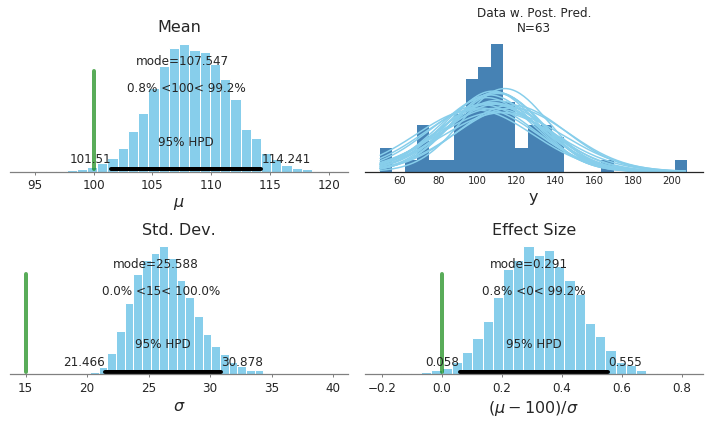

In [45]:
from scipy.stats import norm, t
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

font_d = {'size':16}

# Upper left
pm.plot_posterior(trace['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace)
# Plot only 20 posterior prediction curves. 
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c=color)
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
pm.plot_posterior(trace['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Lower right
pm.plot_posterior((trace['mu']-100)/trace['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

plt.tight_layout();

#### Outliers and robust estimation: T-distribution

In [46]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu_minus_1 = pm.Exponential('nu_minus_1', lam=1/29)
    nu = pm.Deterministic('nu', nu_minus_1 + 1)
    
    y_pred = pm.StudentT('y_pred', mu=mu, sd=sigma, nu=nu, observed=y)

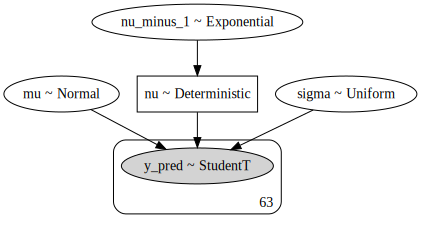

In [47]:
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_1, sigma, mu]
100%|██████████| 2500/2500 [00:14<00:00, 183.25it/s]


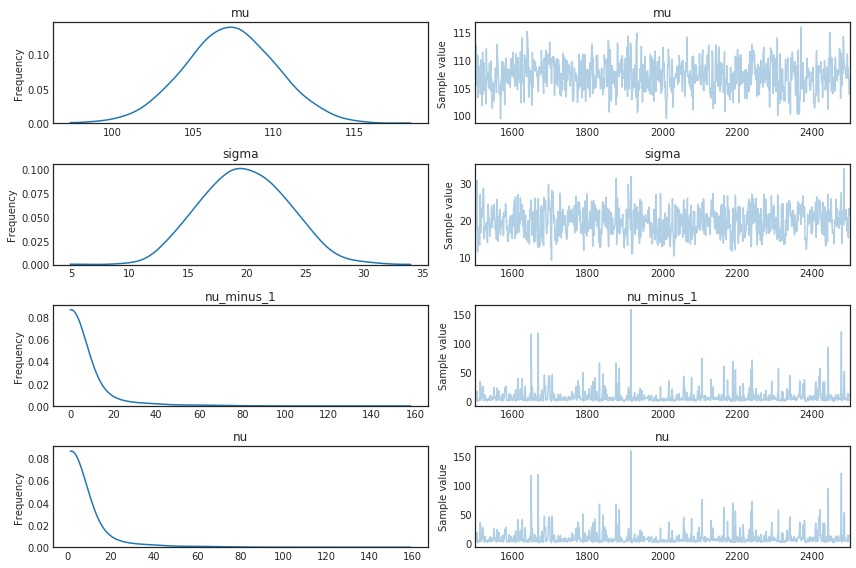

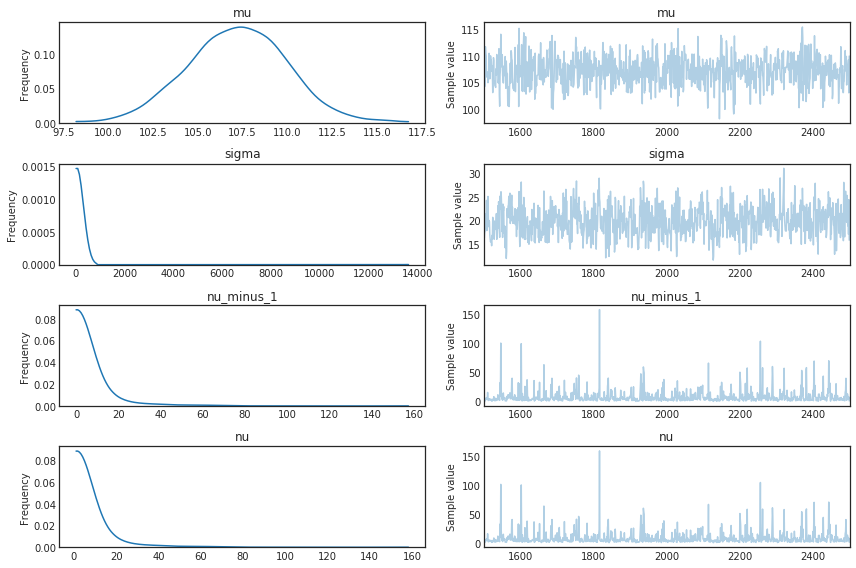

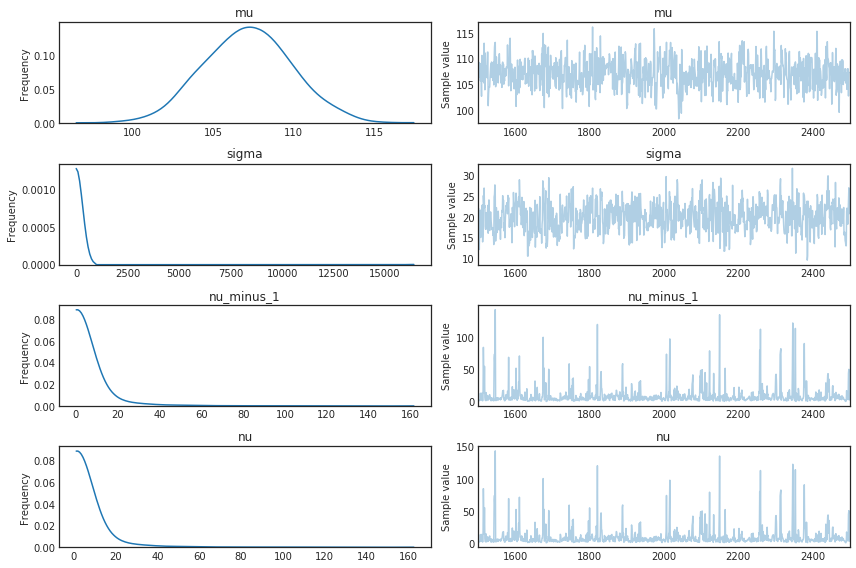

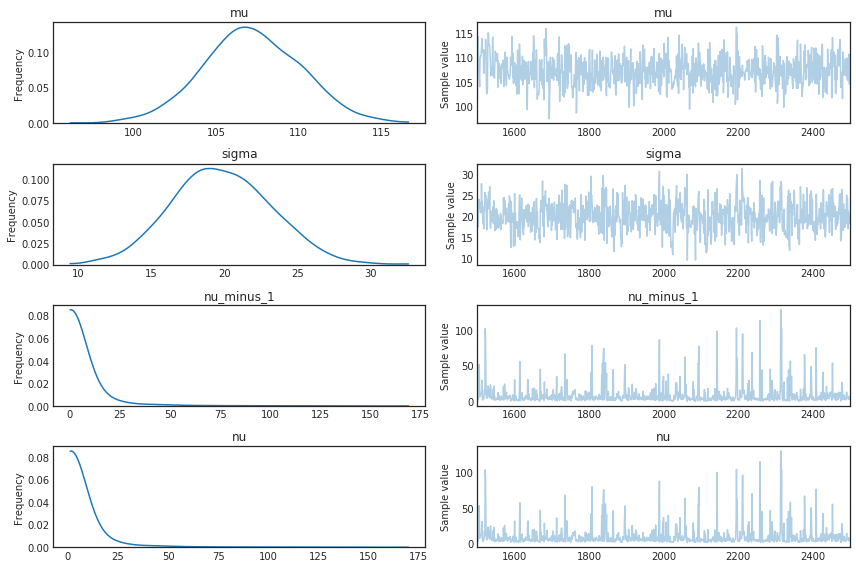

In [50]:
trace = pm.sample(model=model, draws=2000, chains=4, cores=-1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13636b400>,
      dtype=object)

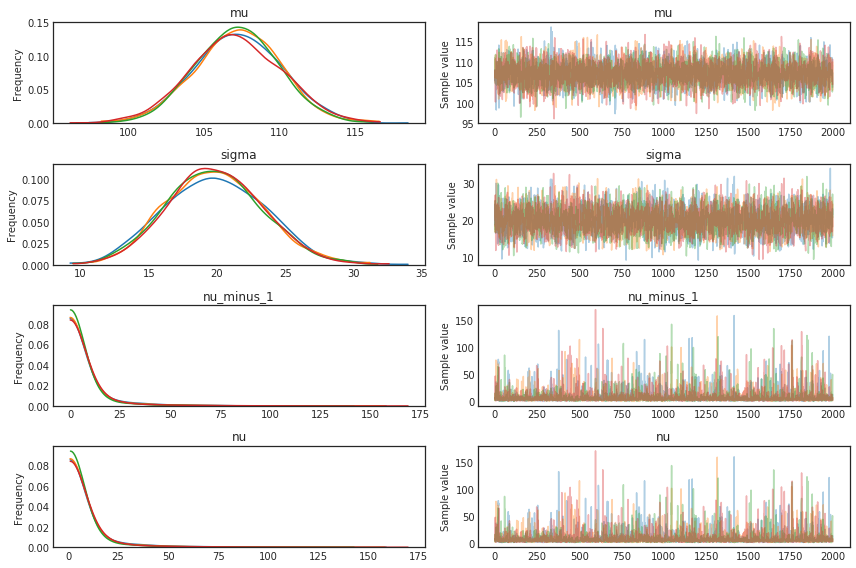

In [51]:
pm.traceplot(trace)

#### Two Groups

In [57]:
df['group_mapping'] = df.Group.map({'Smart Drug': 0, 'Placebo': 1})

In [58]:
n_groups = 2

In [75]:
with pm.Model() as model:
    mu = pm.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_groups)
    sigma = pm.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_groups)
    nu_minus_1 = pm.Exponential('nu_minus_1', lam=1/29, shape=n_groups)
    nu = pm.Deterministic('nu', nu_minus_1 + 1)
    
    y_pred = pm.StudentT('y_pred', mu=mu[df.group_mapping], sd=sigma[df.group_mapping], nu=nu[df.group_mapping], observed=df.Score)

/Users/shubham/shubham/bayesian_stats/kruschke/.env/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


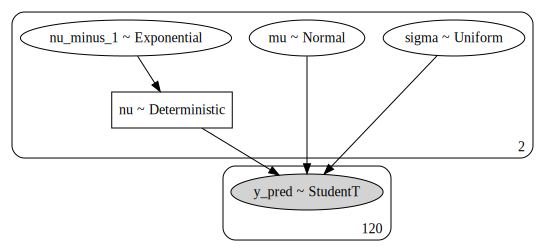

In [76]:
pm.model_to_graphviz(model)

In [78]:
trace = pm.sample(model=model, draws=10000, cores=-1, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_1, sigma, mu]
100%|██████████| 10500/10500 [00:19<00:00, 533.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138458eb8>,
      dtype=object)

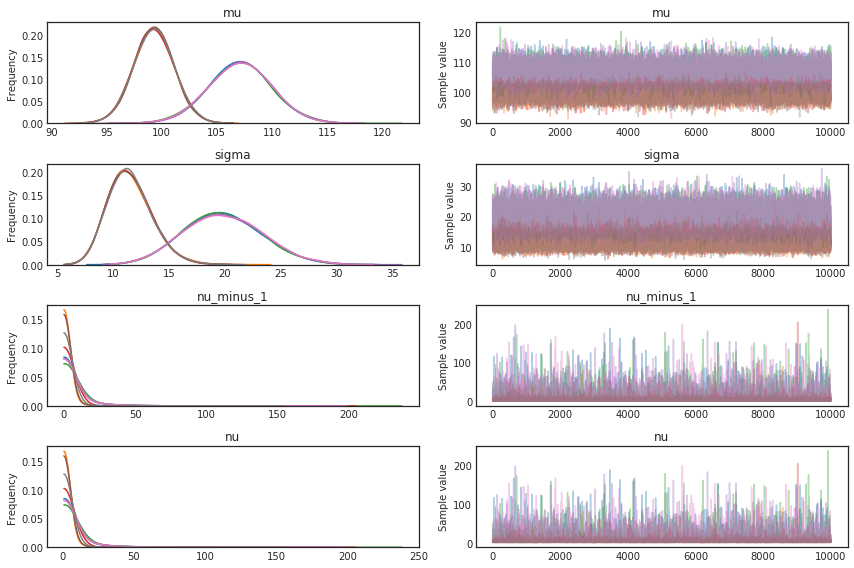

In [79]:
pm.traceplot(trace)

In [80]:
trace_df = pm.trace_to_dataframe(trace)

In [83]:
trace_df['nu__1'].mean()

4.577171193553193